In [1]:

import sys
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/models/')
sys.path.append('/Users/bryangonzalez/Documents/Dartmouth/Research/TheoryOfMind_Bx_experiment/Code/')
import pandas as pd
import numpy as np
import comp_models
import utils
import seaborn as sns


dat = pd.read_csv('../data/bx_data.csv', index_col=0)
fits = pd.read_csv('results/final_model_fits2turker_all.csv', index_col=0)
mod_fits = fits.loc[fits.model == 'inverse RL'].reset_index(drop=True)

In [2]:
# add p2 index to mod_fit df
mod_fits['p2'] = np.nan
for p2 in dat.trustee.unique():
    p2_turkers = dat.loc[dat.trustee == p2, 'turker_id'].unique()
    mod_fits.loc[mod_fits.turker.isin(p2_turkers), 'p2'] = int(p2)



### Separate test set

In [3]:
p2strats = ['GR', 'GA', 'IA', 'MO']
test_p2s = []
for strat in p2strats:
    pTwos = dat.loc[dat.p2_strat == strat, 'trustee'].unique()
    test_p2s.append(pTwos[np.random.randint(len(pTwos))])
test_p2s

testDat = dat.loc[dat.trustee.isin(test_p2s)]
trainDat = dat.loc[~dat.trustee.isin(test_p2s)]

In [4]:
#"train model" i.e. mean param values for training set
alpha = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param1'].mean()
tau = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param2'].mean()

In [5]:
testDat['im_pred'] = np.nan
for p3 in testDat.turker_id.unique():
    g = testDat.loc[testDat.turker_id == p3]
    mod_pred = comp_models.imm_learn(g, utils.folk_params, alpha, tau).astype(int).tolist()
    testDat.loc[testDat.turker_id == p3, 'im_pred'] = mod_pred



/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
testDat['model_pe'] = abs((testDat.im_pred/testDat.im)*100 - (testDat.ret/testDat.im)*100)

/Users/bryangonzalez/opt/anaconda3/envs/mTurk/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
xx = testDat.melt(id_vars=['trustee', 'trial', 'p2_strat'], value_vars=['turker_pe', 'model_pe'],
             var_name='agent', value_name='error')


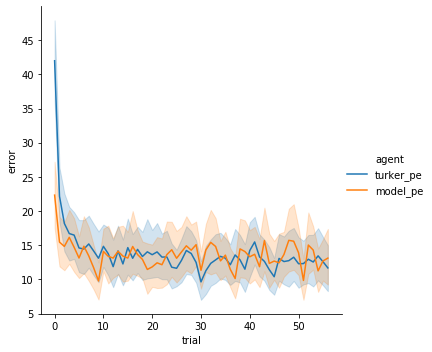

In [10]:
import matplotlib.pyplot as plt
#sns.relplot(x='trial', y='error', hue='agent', col='p2_strat', kind='line', data=xx)
sns.relplot(x='trial', y='error', hue='agent', kind='line', data=xx)
plt.savefig('OoSamp_pred.png')

That didn't work out so well. Cross validate within strategy now.

In [21]:
test_p2s = []
for strat in p2strats:
    pTwos = dat.loc[dat.p2_strat == strat, 'trustee'].unique()
    test_pTwo = pTwos[np.random.randint(len(pTwos))]
    test_p2s.append(test_pTwo)
    #separate
    testDat = dat.loc[dat.trustee == test_pTwo].reset_index(drop=True)
    trainDat = dat.loc[(dat.trustee.isin(pTwos)) & (dat.trustee != test_pTwo)]
    # 'train'
    alpha = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param1'].mean()
    tau = mod_fits.loc[mod_fits.turker.isin(trainDat.turker_id.unique()), 'param2'].mean()
    # predict
    testDat['im_pred'] = np.nan
    for p3 in testDat.turker_id.unique():
        g = testDat.loc[testDat.turker_id == p3]
        mod_pred = comp_models.imm_learn(g, utils.folk_params, alpha, tau).astype(int).tolist()
        testDat.loc[testDat.turker_id == p3, 'im_pred'] = mod_pred
    # compute prediction errors
    testDat['model_pe_'+strat+''] = abs(((testDat.im_pred/testDat.im)*100) - ((testDat.ret/testDat.im)*100))

In [25]:
xx = testDat.melt(id_vars=['trustee','turker_id', 'trial', 'p2_strat'], value_vars=['turker_pe', 'model_pe'],
             var_name='agent', value_name='error')

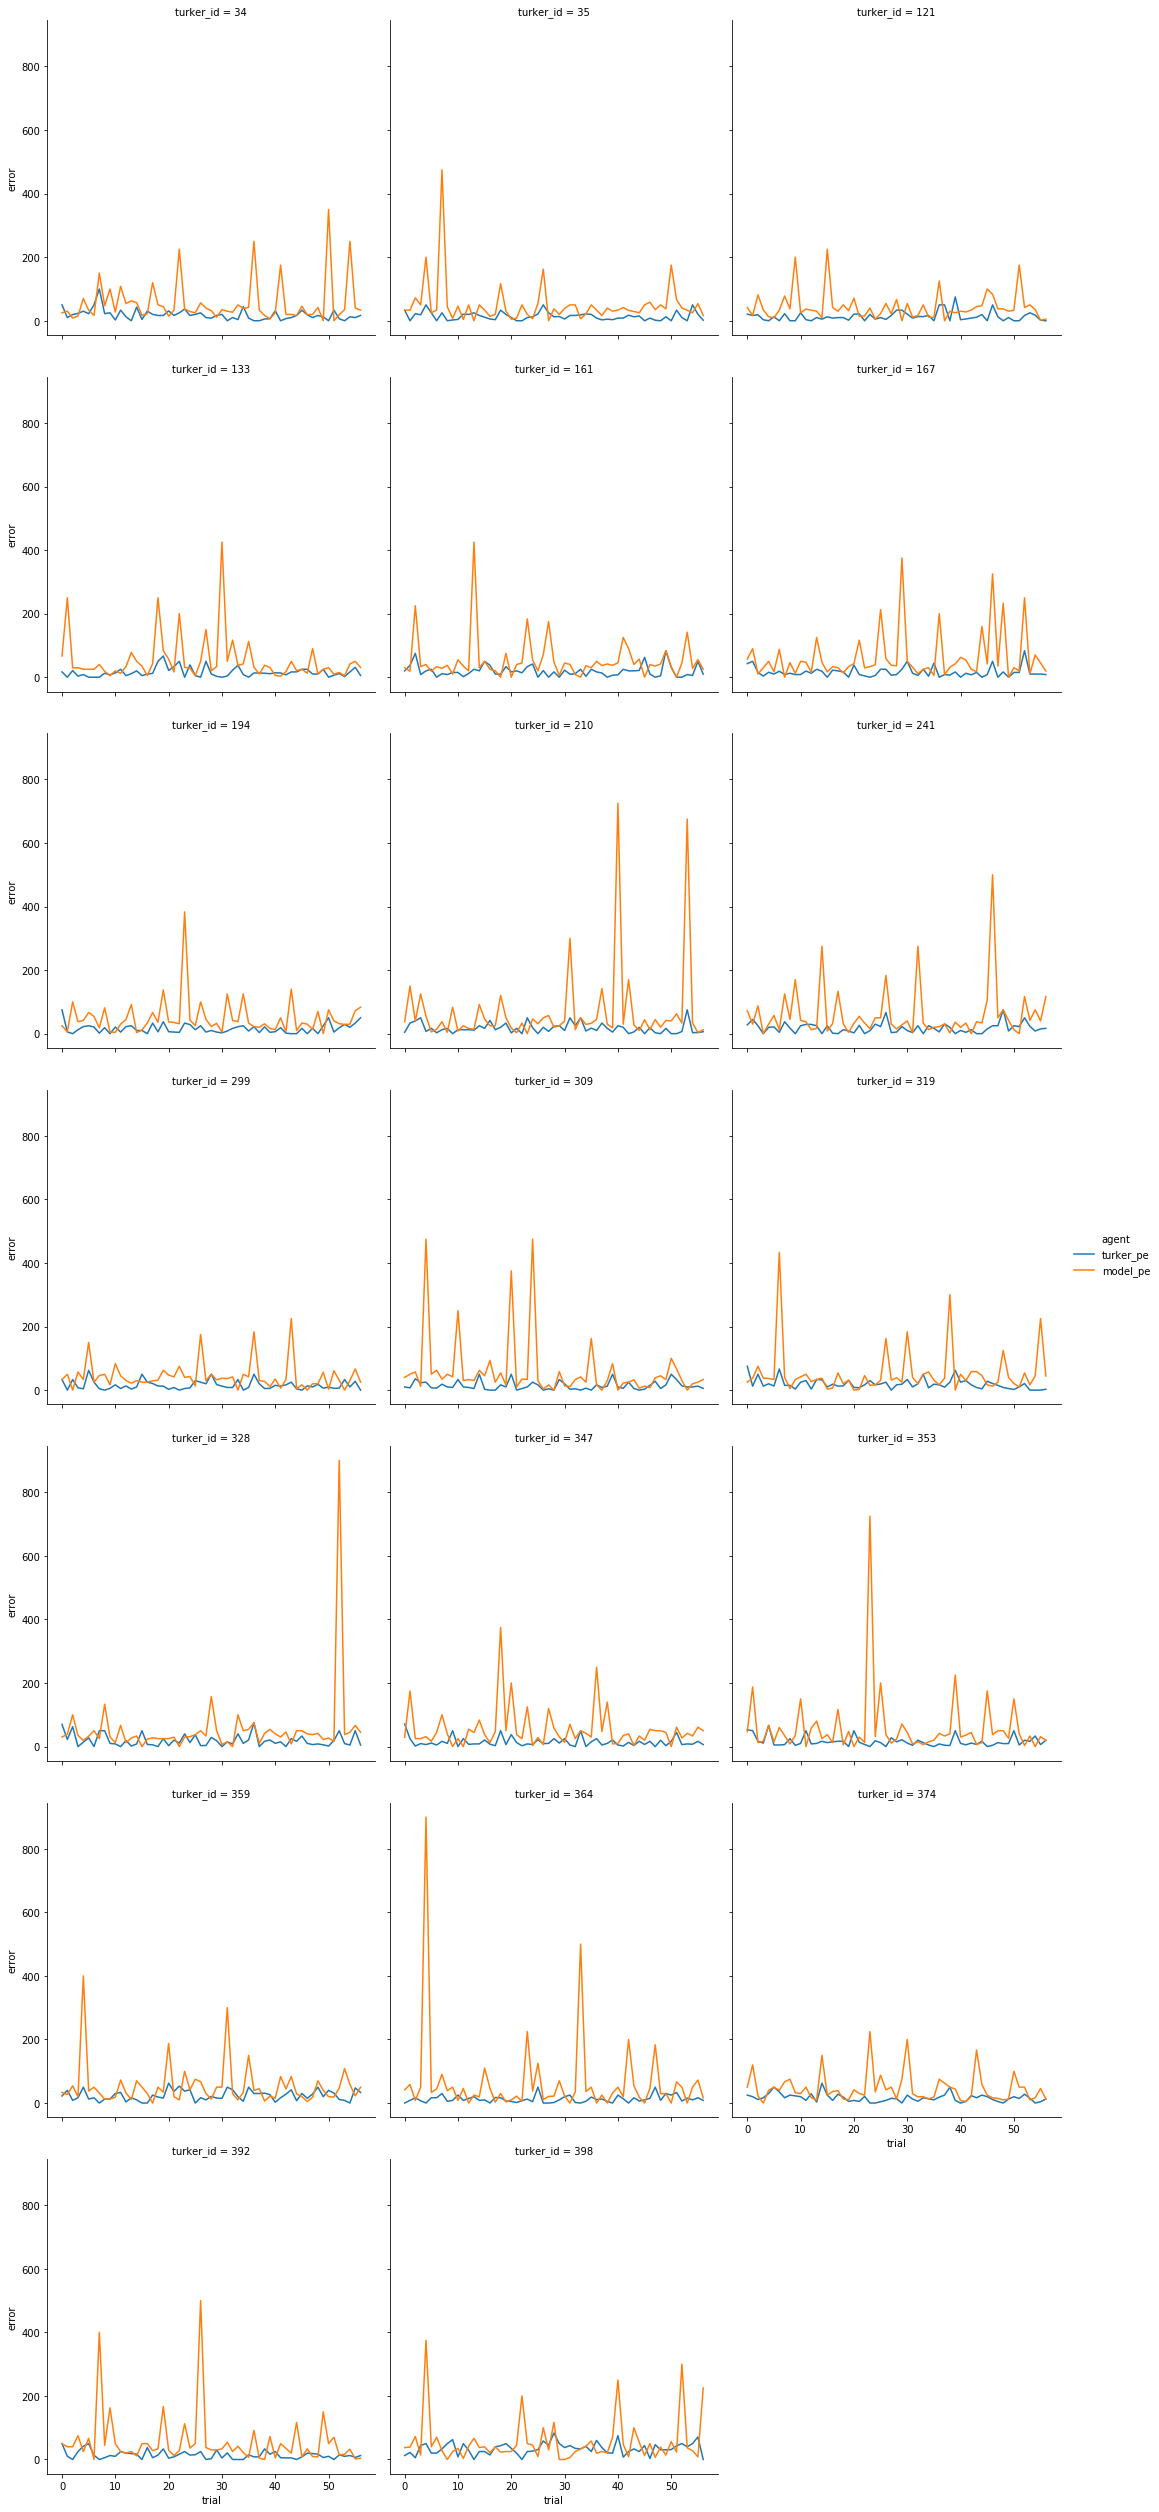

In [27]:
sns.relplot(x='trial', y='error', hue='agent',col='turker_id', col_wrap=3, kind='line', data=xx)